# Field tools

Class ``Field`` only contains general functionality useful for any type of field. ``discretisedfield.tools`` contains a number of more specialised convenicence functions required for certain usecases. Currently, most functions are focused on applications for micromagnetics.

All functions need a ``Field`` object as first parameter.

In [4]:
import discretisedfield as df
import discretisedfield.tools as dft

In [24]:
p1 = (0, 0, 0)
p2 = (10, 10, 10)
cell = (1, 1, 1)
mesh = df.Mesh(p1=p1, p2=p2, cell=cell)

## 1. Topological charge/topological charge density

Topological charge and topological charge density can be computed for vector fields (``dim=3``) only. It is defined for two-dimensional samples only. Therefore, the field must be sliced.

Two different methods are available and can be selected using ``method``:

1. Continuous method:
    $$q = \frac{1}{4\pi} \mathbf{n} \cdot \left(\frac{\partial
    \mathbf{n}}{\partial x} \times \frac{\partial
    \mathbf{n}}{\partial x} \right),$$
    
    where $\mathbf{n}$ is the orientation field.

2. Berg-Luescher method. For Berg-Luescher method the two-dimensional plane is triangulated and contributions to topological charge (density) are computed for each triangle.
   
   Details can be found in:
   - B. Berg and M. Luescher. Definition and statistical distributions of a topological number in the lattice O(3) sigma-model. Nuclear Physics B 190 (2), 412-424 (1981).
   - J.-V. Kim and J. Mulkers. On quantifying the topological charge in micromagnetics using a lattice-based approach. IOP SciNotes 1, 025211 (2020).

Here, we show the calculation for a uniform magnetisation which has a topological charge (density) of zero everywhere.

In [25]:
f = df.Field(mesh, dim=3, value=(1, 1, -1))
f

Field(mesh=Mesh(region=Region(p1=(0, 0, 0), p2=(10, 10, 10)), n=(10, 10, 10), bc='', subregions={}), dim=3)

In [26]:
dft.topological_charge(f.plane('z'))

0.0

In [27]:
dft.topological_charge(f.plane('z'), method='berg-luescher')

0.0

Topological charge density returns a ``Field`` object which we can plot.

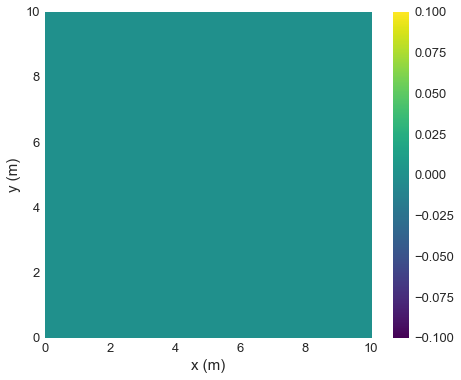

In [28]:
dft.topological_charge_density(f.plane('z')).mpl()

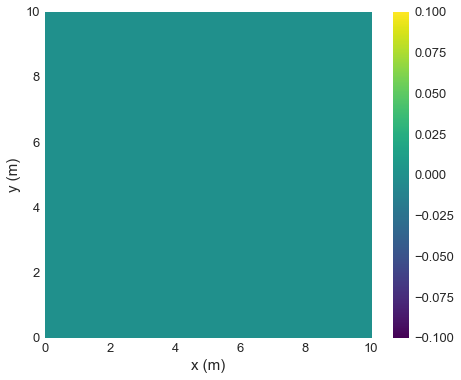

In [29]:
dft.topological_charge_density(f.plane('z'), method='berg-luescher').mpl()

Topological charge has an additional option ``absolute``. If ``True``, the absolute value of topological charge density is computed before integration. This can be usefull for systems with areas of opposite sign of topological charge density to avoid cancellation.

In [30]:
dft.topological_charge(f.plane('z'), absolute=True)

0.0

In [31]:
dft.topological_charge(f.plane('z'), method='berg-luescher', absolute=True)

0.0

## 2. Angles between cells

There are two functions to calculate angles between neighbouring cells. This is only possible for vector fields (``dim=3``).

To visualise this, we use a field with a step function.

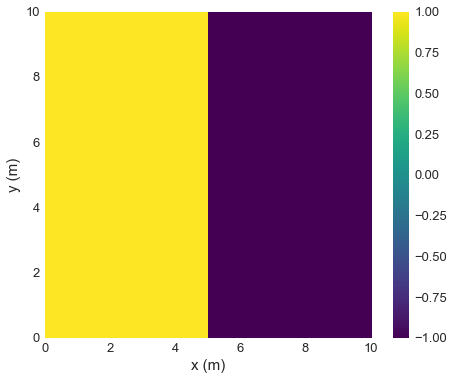

In [32]:
def init_value(p):
    x, _, _ = p
    if x < 5:
        return (0, 0, 1)
    else:
        return (0, 0, -1)

field = df.Field(mesh, dim=3, value=init_value)
field.plane('z').z.mpl_scalar()

The first function computes angles between neighbouring cells in one given direction (``x``, ``y``, or ``z``). It returns a ``Field`` object. The dimensionality is reduced by one in the specified direction. Angles can be computed in radians (``units='rad'``, default) or degrees (``units='deg'``).

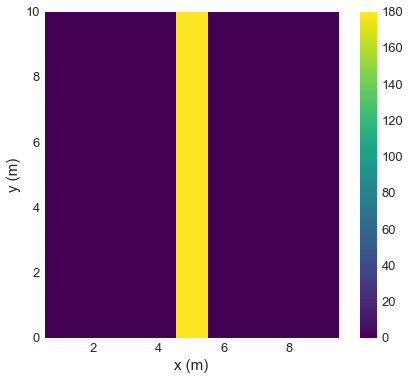

In [43]:
angles_x = dft.neigbouring_cell_angle(field, direction='x', units='deg')
angles_x.plane('z').mpl()

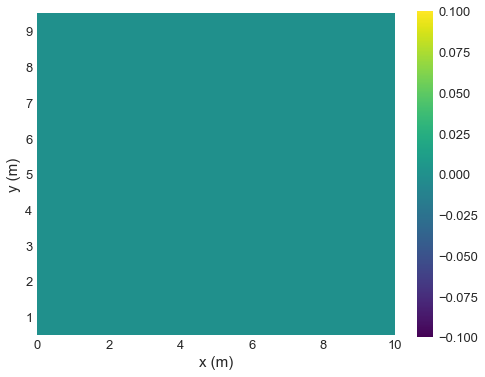

In [44]:
angles_y = dft.neigbouring_cell_angle(field, direction='y')
angles_y.plane('z').mpl()

In [38]:
field.array.shape

(10, 10, 10, 3)

In [39]:
angles_y.array.shape

(10, 9, 10, 1)

The second function returns a ``Field`` object with the same dimensions as the given field. For each cell angles to all six neighbouring cells are computed and the maximum value is used. Missing cells at boundaries are treated as having angle zero, boundary conditions are not taken into account. Angles can be computed in radians or degrees.

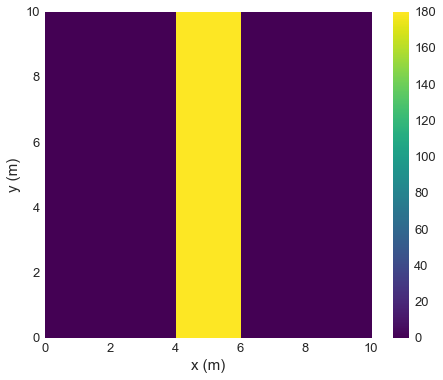

In [45]:
angle_max = dft.max_neigbouring_cell_angle(field, units='deg')
angle_max.plane('z').mpl()

In [46]:
angle_max.array.shape

(10, 10, 10, 1)

The third function related to cell angles can be used to compute the number of regions where cell angles are above a certain threashold ``min_angle``. In this context a region is a number of connected cells, all having neighbouring cell angles above the given threashold. Similar to the functions described above, it is possible to either specify a ``direction`` (``x``, ``y``, or ``z``) or use the maximum of all directions (``direction=None``, default). ``min_angle`` can be in radians (``units='rad'``, default) or degrees (``units='deg'``).

Cell angles in ``y`` direction are all zero:

In [47]:
dft.count_large_cell_angle_regions(field, min_angle=1, direction='y')

0

Using the maximum of all angles, there is one region between ``x=4`` and ``x=6`` with cell angles of 180°.

In [48]:
dft.count_large_cell_angle_regions(field, min_angle=90, units='deg')

1

## 3. Emergent magnetic field and counting of BPs
TODO